In [25]:
import pandas as pd

df = pd.read_csv("Merged_Microplastic_Data.csv")

null_counts = df.isnull().sum()
print(null_counts)

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64


In [26]:
df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
4,4,10.1039/c6ay01184e,1|10.1039/c6ay01184e,Germany,Germany,bottled water,19-Oct,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
604,604,10.1016/j.scitotenv.2021.148001,Aut|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,750,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
605,605,10.1016/j.scitotenv.2021.148001,Win|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,540,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


In [27]:
df = df[~df['Location'].isnull()]

df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])
df = df.fillna('Unknown')

df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
4,4,10.1039/c6ay01184e,1|10.1039/c6ay01184e,Germany,Germany,bottled water,19-Oct,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
604,604,10.1016/j.scitotenv.2021.148001,Aut|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,750,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
605,605,10.1016/j.scitotenv.2021.148001,Win|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,540,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


In [28]:
df['Location'].unique()

array(['Germany', 'Jakarta, Indonesia', 'Bali, Indonesia',
       'Medan, Indonesia', 'Chennai, India', 'Mumbai, India',
       'New Delhi, India', 'Nairobi, Kenya', 'Mexico City, Mexico',
       'Tijuana, Mexico', 'Reynosa, Mexico', 'Fredonia, NY, USA',
       'Sao Paulo, Brazil', 'Aparecida de Goiania, Brazil',
       'Rio de Janerio, Brazil', 'Beirut, Lebanon', 'Bangkok, Thailand',
       'Jinan, China', 'Beijing, China', 'Qingdao, China', 'Havana, Cuba',
       'Quito, Ecuador', 'Paris, France',
       'Berlin, Germany; Tubingen, Germany', 'Ner Delhi, India',
       'Depok City, Indonesia; Desa Puspanegara, Indonesia; Jakarta, Indonesia; Jatirahayu, Indonesia; Kedaung, Indonesia; Menteng, Indonesia; North Paninggilan, Indonesia; Pasireurih, Indonesia; South Tangerang City, Indonesia; Sukatani, Indonesia; Teluknaga, Indonesia; Warnasari, Indonesia',
       'Dublin, Ireland', 'Pavia, Italy',
       'Beirut, Lebanon; Burj el Brajneh, Lebanon; Choueifat, Lebanon; Ghobayreh, Lebanon; Kh

In [29]:
# Checking correlation between concentration and geolocation



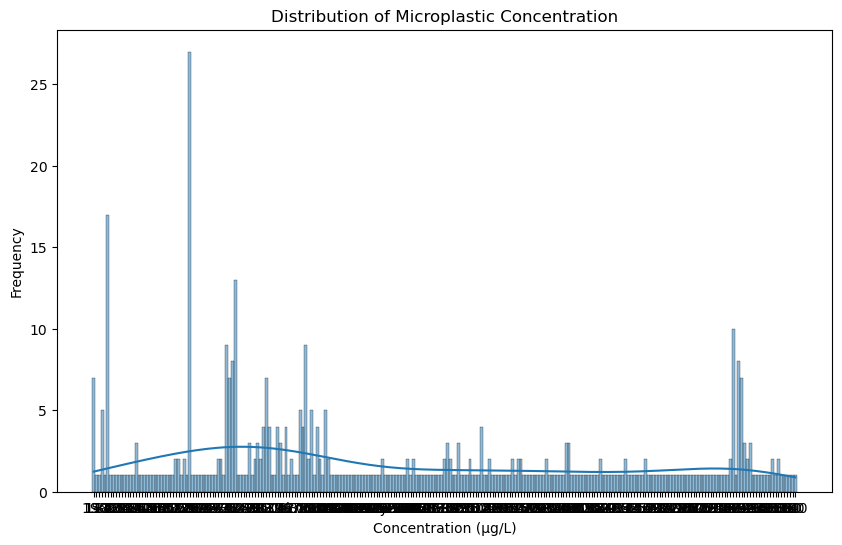

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Concentration'], kde=True, bins=50)
plt.title("Distribution of Microplastic Concentration")
plt.xlabel("Concentration (µg/L)")
plt.ylabel("Frequency")
plt.show()


### Microplastic Concentration by Filtration Method

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Filtration', y='Concentration')
plt.title("Microplastic Concentration by Filtration Method")
plt.xlabel("Filtration Method")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=90)
plt.show()


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1200x600 with 0 Axes>

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Source', y='Concentration', estimator='mean')
plt.title("Average Microplastic Concentration by Source")
plt.xlabel("Source Type")
plt.ylabel("Average Concentration (µg/L)")
plt.xticks(rotation=45)
plt.show()


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1000x600 with 0 Axes>

In [33]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Countries', y='Concentration')
plt.title("Microplastic Concentration by Country")
plt.xlabel("Country")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=70)
plt.show()


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1400x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

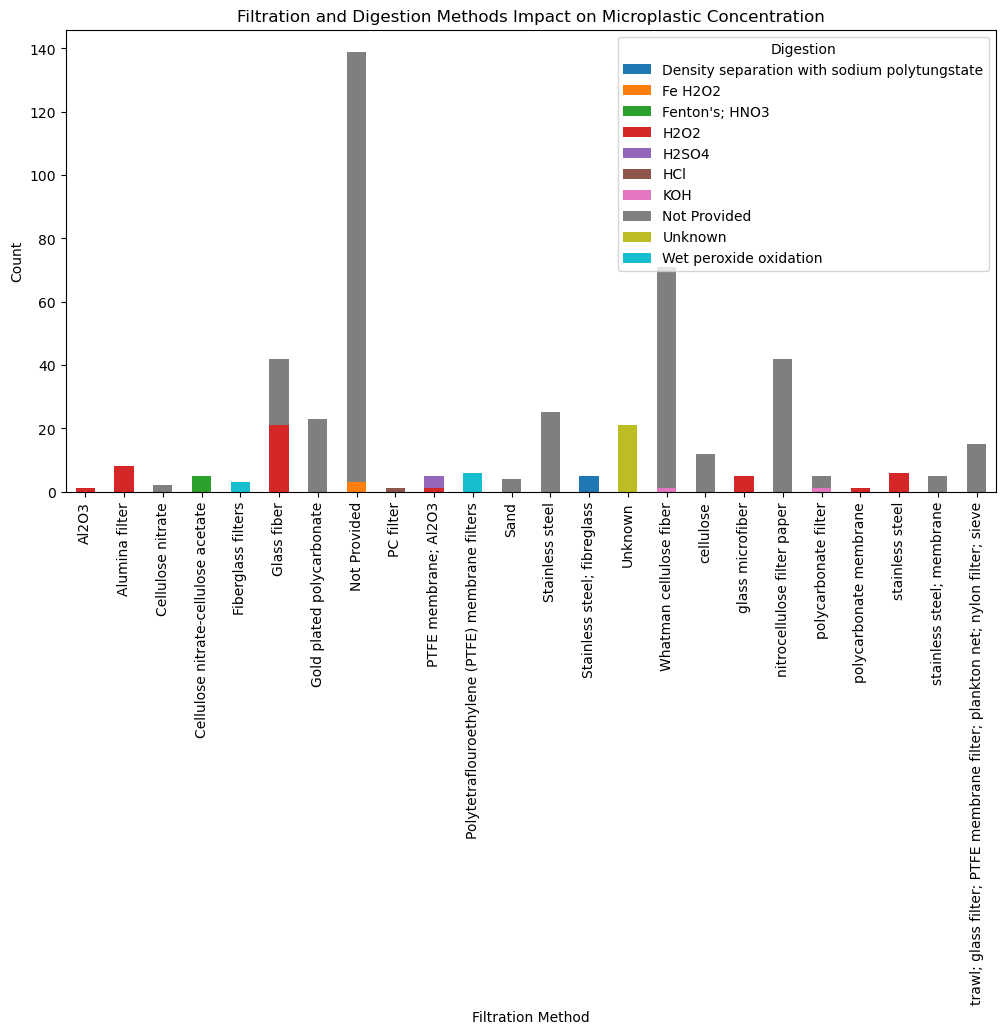

In [34]:
plt.figure(figsize=(12, 6))
filtration_digestion_group = df.groupby(['Filtration', 'Digestion']).size().unstack()
filtration_digestion_group.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Filtration and Digestion Methods Impact on Microplastic Concentration")
plt.xlabel("Filtration Method")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


In [35]:
from scipy import stats
filtration_groups = df.groupby('Filtration')['Concentration'].apply(list)
digestion_groups = df.groupby('Digestion')['Concentration'].apply(list)

# Perform ANOVA for Filtration Methods
f_stat, p_val = stats.f_oneway(*filtration_groups)
print(f"ANOVA result for Filtration methods: F-statistic = {f_stat}, p-value = {p_val}")

# Perform ANOVA for Digestion Methods
f_stat, p_val = stats.f_oneway(*digestion_groups)
print(f"ANOVA result for Digestion methods: F-statistic = {f_stat}, p-value = {p_val}")


ValueError: could not convert string to float: '19-Oct'

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA model for Filtration methods
model = ols('Concentration ~ Filtration', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Tukey's HSD test
tukey = pairwise_tukeyhsd(df['Concentration'], df['Filtration'], alpha=0.05)
print(tukey)


ValueError: endog has evaluated to an array with multiple columns that has shape (452, 249). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
df_clean = df.dropna(subset=['Concentration', 'Countries'])  # Remove missing values

# Aggregate Data
country_stats = df_clean.groupby('Countries').agg(
    max_concentration=('Concentration', 'max'),
    mean_concentration=('Concentration', 'mean'),
    sample_count=('Concentration', 'count')
).reset_index()

# Sort by highest max concentration
country_stats = country_stats.sort_values(by='max_concentration', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=country_stats, x='Countries', y='max_concentration', palette='Reds_r')

plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Max Microplastic Concentration')
plt.title('Highest Microplastic Concentration by Country')
plt.show()


TypeError: Could not convert 1.50.480.280.180.960.912.76 to numeric

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
df_clean = df.dropna(subset=['Concentration', 'Countries'])  # Remove missing values

# Aggregate Data
country_stats = df_clean.groupby('Countries').agg(
    max_concentration=('Concentration', 'max'),
    mean_concentration=('Concentration', 'mean'),
    sample_count=('Concentration', 'count')
).reset_index()

# Sort by highest max concentration
country_stats = country_stats.sort_values(by='max_concentration', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=country_stats, x='Countries', y='max_concentration', palette='Reds_r')

# Add data labels
for index, row in enumerate(country_stats.itertuples()):
    ax.text(index, row.max_concentration + 10, round(row.max_concentration, 2), 
            ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=95)
plt.xlabel('Country')
plt.ylabel('Max Microplastic Concentration')
plt.title('Highest Microplastic Concentration by Country')

plt.show()


TypeError: Could not convert 1.50.480.280.180.960.912.76 to numeric

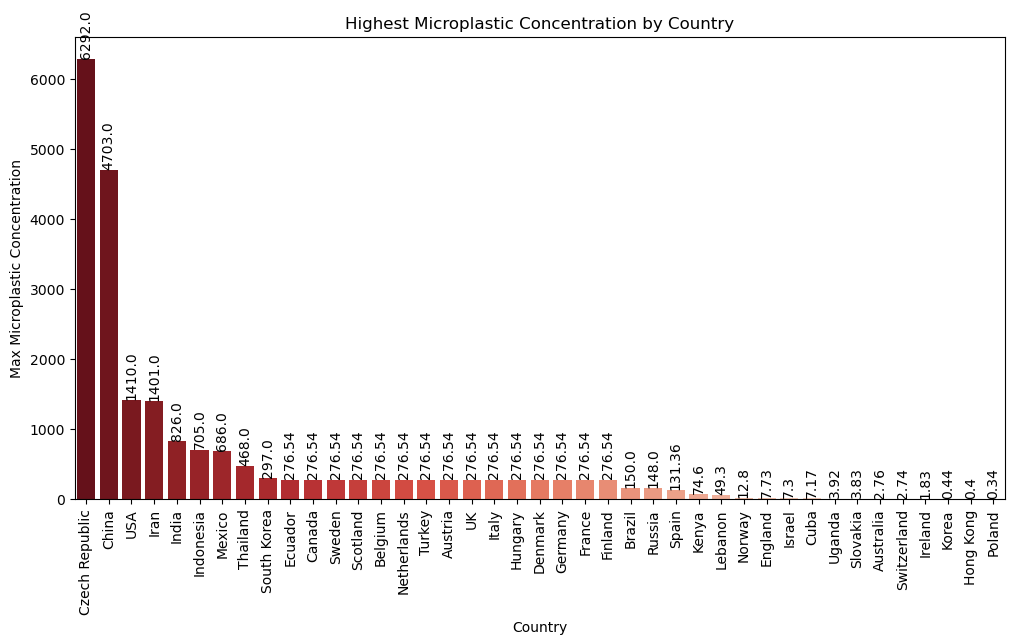

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named df
df_clean = df.dropna(subset=['Concentration', 'Countries'])  # Remove missing values

# Aggregate Data
country_stats = df_clean.groupby('Countries').agg(
    max_concentration=('Concentration', 'max'),
    mean_concentration=('Concentration', 'mean'),
    sample_count=('Concentration', 'count')
).reset_index()

# Sort by highest max concentration
country_stats = country_stats.sort_values(by='max_concentration', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=country_stats, x='Countries', y='max_concentration', palette='Reds_r')

# Add vertical data labels
for index, row in enumerate(country_stats.itertuples()):
    ax.text(index, row.max_concentration + 10, str(round(row.max_concentration, 2)), 
            ha='center', va='bottom', fontsize=10, rotation=90)  # Rotate text vertically

plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Max Microplastic Concentration')
plt.title('Highest Microplastic Concentration by Country')

plt.show()


In [42]:
# Count the number of entries per country
country_counts = df['Countries'].value_counts()

# Display the result
print(country_counts)


Countries
China             139
Germany            49
Mexico             45
USA                34
Denmark            20
India              17
Czech Republic     15
Ecuador            13
Finland            10
Spain              10
Indonesia           9
Netherlands         8
Australia           7
Iran                7
Korea               7
France              6
Canada              6
South Korea         5
Turkey              5
Belgium             4
Italy               4
Brazil              4
Norway              3
Scotland            3
Sweden              2
Israel              2
UK                  2
Lebanon             2
Hong Kong           2
Thailand            2
Austria             1
Uganda              1
Slovakia            1
Ireland             1
England             1
Cuba                1
Poland              1
Russia              1
Switzerland         1
Kenya               1
Hungary             1
Name: count, dtype: int64


In [53]:
usa = df[df['Countries'] == "USA"]

# display max rows and columns
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

usa

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
20,20,10.3389/fchem.2018.00407,PRD 05 24 17 11:29|10.3389/fchem.2018.00407,"Fredonia, NY, USA",USA,bottled water,58.2,particles/L,39.78373,-100.445882,Pre packaged bevarage cartons,Not Provided,Glass fiber,1.5 um,Nile red; visual,FTIR,DI procedural blanks
21,21,10.3389/fchem.2018.00407,07.142018 2|10.3389/fchem.2018.00407,"Fredonia, NY, USA",USA,bottled water,1410,particles/L,39.78373,-100.445882,Pre packaged bevarage cartons,Not Provided,Glass fiber,1.5 um,Nile red; visual,FTIR,DI procedural blanks
46,46,10.1371/journal.pone.0194970,Tap Water_USA|10.1371/journal.pone.0194970,"Alpena, USA; Buffalo, USA; Chicago, USA; Clayt...",USA,tap water,9.24,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
47,47,10.1371/journal.pone.0194970,Bottled Water|10.1371/journal.pone.0194970,USA,USA,bottled water,3.57,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
48,48,10.1371/journal.pone.0194970,Lake Superior 1|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,0.67,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
49,49,10.1371/journal.pone.0194970,Lake Superior 2|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,4.33,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
50,50,10.1371/journal.pone.0194970,Lake Superior 3|10.1371/journal.pone.0194970,Lake Superior,USA,bottled water,3.33,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
51,51,10.1371/journal.pone.0194970,Lake Michigan 1|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,1.33,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
52,52,10.1371/journal.pone.0194970,Lake Michigan 2|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,0,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
53,53,10.1371/journal.pone.0194970,Lake Michigan 3|10.1371/journal.pone.0194970,Lake Michigan,USA,bottled water,14.3,particles/L,39.78373,-100.445882,"Tap water, beer",Not Provided,Whatman cellulose fiber,2.5 um,Rose Bengal stain; visual,FTIR,DI procedural blanks
